# Statistical Analysis of Bay Area Bike Share Data

> From our initial Visual Exploratory Data Analysis on the Bay Area BIke Share dataset, we inferred that the vast majority of the trips are taken by cummuters, who are subscribers.
>
> We will also be retaining from previous analysis that we only need concern ourselves with trips no more than 60 minutes in duration
>
> Predicting ridership appears pretty easy, commuters need to commute, and customers seem to be mostly starting or ending their trips at propular tourist destinations.
>
> <b>1</b> Are Customer or Subscriber trip counts affected by Rain?
> 
> <b>2</b> Are Customer or Subscriber trip counts affected by Hot or Cold Temperatures?
>
> <b>3</b> Are Customer or Subscriber trip counts affected by Humidity Temperatures?

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
from scipy import stats
import math
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from glob import glob

import seaborn as sns
# sns.set()
sns.set_style('whitegrid')
sns.set_context("poster")

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

font = {'size'   : 50}
matplotlib.rc('font', **font)

TITLE_FONT_SIZE = 25
LABEL_FONT_SIZE = 20
TICK_FONT_SIZE  = 15

In [3]:
day_labels = ['MON','TUE','WED','THU','FRI','SAT','SUN']
day_labels_full = ['MONDAY','TUESDAY','WEDNESDAY','THURSDAY','FRIDAY','SATURDAY','SUNDAY']
month_labels = ['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']

ordered_zipcodes = [94107, 95113, 94041, 94301, 94063]

# Load Data

## Trip Data

In [4]:
print('[%s] Loading Trip Data...' % datetime.datetime.now().time())

trips_df = pd.DataFrame()
trip_data_file = '../clean_data/bayareabikeshare/trip_data_cleaned.csv'

# Chunk Settings
chunks = []
chunk_counter = 1
chunksize = 10000
num_chunks = math.ceil(sum(1 for row in open(trip_data_file, 'r'))/chunksize)

# import file in chunks
for chunk in pd.read_csv(trip_data_file, chunksize=chunksize, iterator=True, index_col=0, parse_dates=['start_date', 'end_date']):
    
    # append chunk to chunks list
    chunks.append(chunk)

    if chunk_counter == 1 or chunk_counter % math.ceil(num_chunks/10) == 0 or chunk_counter == num_chunks:
        print('\t\t[%s] finished chunk %s of %s' % (datetime.datetime.now().time(), chunk_counter, num_chunks))
    chunk_counter += 1

trips_df = pd.concat(chunks)
trips_df.user_type = trips_df.user_type.astype('category')

trips_df.drop_duplicates(inplace=True)
trips_df.sort_values('trip_id', inplace=True)
trips_df.reset_index(inplace=True, drop=True)

print('[%s] Complete!' % datetime.datetime.now().time())

[17:33:46.137744] Loading Trip Data...
		[17:33:46.805106] finished chunk 1 of 96
		[17:33:47.331629] finished chunk 10 of 96
		[17:33:47.876988] finished chunk 20 of 96
		[17:33:48.453772] finished chunk 30 of 96
		[17:33:49.021720] finished chunk 40 of 96
		[17:33:49.589642] finished chunk 50 of 96
		[17:33:50.155500] finished chunk 60 of 96
		[17:33:50.744028] finished chunk 70 of 96
		[17:33:51.329613] finished chunk 80 of 96
		[17:33:51.906886] finished chunk 90 of 96
		[17:33:52.217303] finished chunk 96 of 96
[17:33:54.484236] Complete!


In [5]:
trips = trips_df.copy()

In [6]:
trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 955557 entries, 0 to 955556
Data columns (total 12 columns):
trip_id               955557 non-null int64
duration              955557 non-null int64
start_date            955557 non-null datetime64[ns]
start_station_name    955557 non-null object
start_terminal        955557 non-null int64
end_date              955557 non-null datetime64[ns]
end_station_name      955557 non-null object
end_terminal          955557 non-null int64
bike_id               955557 non-null int64
user_type             955557 non-null category
user_zip              955557 non-null int64
duration_minutes      955557 non-null float64
dtypes: category(1), datetime64[ns](2), float64(1), int64(6), object(2)
memory usage: 81.1+ MB


## Darksky Weather Data

In [7]:
print('[%s] Loading Weather Data...' % datetime.datetime.now().time())

weather_df = pd.DataFrame()
weather_data_file = '../clean_data/darksky/darksky_cleaned.csv'

# Chunk Settings
chunks = []
chunk_counter = 1
chunksize = 10000
num_chunks = math.ceil(sum(1 for row in open(weather_data_file, 'r'))/chunksize)

# import file in chunks
for chunk in pd.read_csv(weather_data_file, chunksize=chunksize, iterator=True, index_col=0, parse_dates=['time_corrected']):
    
    # append chunk to chunks list
    chunks.append(chunk)

    if chunk_counter == 1 or chunk_counter % math.ceil(num_chunks/10) == 0 or chunk_counter == num_chunks:
        print('\t\t[%s] finished chunk %s of %s' % (datetime.datetime.now().time(), chunk_counter, num_chunks))
    chunk_counter += 1

weather_df = pd.concat(chunks)

weather_df.drop_duplicates(inplace=True)

weather_df.sort_values(['time_corrected', 'zip_code'], inplace=True)
weather_df.reset_index(inplace=True, drop=True)

print('[%s] Complete!' % datetime.datetime.now().time())

[17:33:55.137499] Loading Weather Data...
		[17:33:56.512286] finished chunk 1 of 159
		[17:33:57.802903] finished chunk 16 of 159
		[17:33:59.064406] finished chunk 32 of 159
		[17:34:00.411638] finished chunk 48 of 159
		[17:34:01.885078] finished chunk 64 of 159
		[17:34:03.277315] finished chunk 80 of 159
		[17:34:05.809594] finished chunk 96 of 159
		[17:34:07.463879] finished chunk 112 of 159
		[17:34:08.847299] finished chunk 128 of 159
		[17:34:10.056972] finished chunk 144 of 159
		[17:34:11.153830] finished chunk 159 of 159
[17:34:16.801631] Complete!


In [8]:
weather = weather_df.copy()

In [9]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1586743 entries, 0 to 1586742
Data columns (total 22 columns):
apparentTemperature    1586743 non-null float64
cloudCover             1363580 non-null float64
daily_icon             1586743 non-null object
daily_summary          1586743 non-null object
dewPoint               1586743 non-null float64
hourly_icon            1586743 non-null object
hourly_summary         1586743 non-null object
humidity               1586743 non-null float64
latitude               1586743 non-null float64
longitude              1586743 non-null float64
precipIntensity        1586743 non-null float64
precipProbability      1586743 non-null float64
precipType             1586743 non-null int64
pressure               1586743 non-null float64
temperature            1586743 non-null float64
time_corrected         1586743 non-null datetime64[ns]
visibility             1586743 non-null float64
windBearing            1586186 non-null float64
windSpeed             

In [10]:
weather.head(3)

,apparentTemperature,cloudCover,daily_icon,daily_summary,dewPoint,hourly_icon,hourly_summary,humidity,latitude,longitude,...,precipType,pressure,temperature,time_corrected,visibility,windBearing,windSpeed,station_id,landmark,zip_code
0,64.61,0.0,clear-day,Clear throughout the day.,61.02,clear-night,Clear,0.89,37.394358,-122.076713,...,0,1014.81,64.30,2013-08-29,9.31,338.0,5.23,28,Mountain View,94041
1,65.29,0.0,clear-day,Clear throughout the day.,61.38,clear-night,Clear,0.88,37.395337,-122.052476,...,0,1014.93,64.94,2013-08-29,9.62,347.0,5.76,30,Mountain View,94041
2,64.45,0.0,clear-day,Clear throughout the day.,60.93,clear-night,Clear,0.89,37.420909,-122.080623,...,0,1014.78,64.13,2013-08-29,9.24,334.0,5.12,33,Mountain View,94041


In [11]:
trips.head(3)

,trip_id,duration,start_date,start_station_name,start_terminal,end_date,end_station_name,end_terminal,bike_id,user_type,user_zip,duration_minutes
0,4069,174,2013-08-29 09:08:00,2nd at South Park,64,2013-08-29 09:11:00,2nd at South Park,64,288,Subscriber,94114,2.900000
1,4073,1067,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:42:00,San Francisco Caltrain 2 (330 Townsend),69,321,Subscriber,94703,17.783333
2,4074,1131,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,317,Subscriber,94115,18.850000


# Merge Weather Data to Trips

In [12]:
print('Number of \'trips\' records    {}'.format(str(trips.shape[0]).rjust(9)))
print('Number of \'weather\' records  {}'.format(str(weather.shape[0]).rjust(9)))

Number of 'trips' records       955557
Number of 'weather' records    1586743


In [13]:
merged = trips.merge(weather, left_on=[trips.start_terminal, trips.start_date.dt.date, trips.start_date.dt.hour],
                              right_on=[weather.station_id, weather.time_corrected.dt.date, weather.time_corrected.dt.hour], how='left')

In [14]:
print('Number of \'trips\' records    {}'.format(str(trips.shape[0]).rjust(9)))
print('Number of \'weather\' records  {}'.format(str(weather.shape[0]).rjust(9)))
print('Number of \'merged\' records   {}'.format(str(merged.shape[0]).rjust(9)))

Number of 'trips' records       955557
Number of 'weather' records    1586743
Number of 'merged' records      982013


In [15]:
merged = merged[merged.zip_code.isin(ordered_zipcodes)]
merged.drop_duplicates(subset='trip_id', keep='first', inplace=True)

merged.sort_values('trip_id', inplace=True)
merged.reset_index(inplace=True, drop=True)

In [16]:
print('Number of \'trips\' records    {}'.format(str(trips.shape[0]).rjust(9)))
print('Number of \'weather\' records  {}'.format(str(weather.shape[0]).rjust(9)))
print('Number of \'merged\' records   {}'.format(str(merged.shape[0]).rjust(9)))

Number of 'trips' records       955557
Number of 'weather' records    1586743
Number of 'merged' records      955552


## Cleanup

In [17]:
merged.cloudCover.fillna(0, inplace=True)
merged.windBearing.fillna(0, inplace=True)
merged.windSpeed.fillna(0, inplace=True)

In [18]:
merged.daily_icon = merged.daily_icon.astype('category')
merged.hourly_icon = merged.hourly_icon.astype('category')
merged.landmark = merged.landmark.astype('category')

In [19]:
merged.rename(columns={'time_corrected': 'forecast_time'}, inplace=True)

In [20]:
merged.dropna(subset=['zip_code'], axis=0, inplace=True)
merged.drop(['zip_code'], axis=1, inplace=True)

merged.sort_values('trip_id', inplace=True)
merged.reset_index(inplace=True, drop=True)

In [21]:
merged.describe()

,trip_id,duration,start_terminal,end_terminal,bike_id,user_zip,duration_minutes,apparentTemperature,cloudCover,dewPoint,...,longitude,precipIntensity,precipProbability,precipType,pressure,temperature,visibility,windBearing,windSpeed,station_id
count,9.555520e+05,955552.000000,955552.000000,955552.000000,955552.000000,955552.000000,955552.000000,955552.000000,955552.000000,955552.000000,...,955552.000000,955552.000000,955552.000000,955552.000000,955552.000000,955552.000000,955552.000000,955552.000000,955552.000000,955552.000000
mean,6.745806e+05,595.602811,58.246774,58.204344,423.711563,91699.128494,9.926714,60.284306,0.146400,49.643055,...,-122.362108,0.000616,0.014735,0.027856,1016.064723,60.350995,8.974309,242.378313,6.578311,58.246774
std,3.846615e+05,405.989136,16.775144,16.856009,157.633673,14126.722231,6.766486,6.670892,0.166706,6.185388,...,0.124105,0.007043,0.100622,0.164561,4.512946,6.506998,1.200525,77.919692,3.688077,16.775144
min,4.069000e+03,60.000000,2.000000,2.000000,9.000000,0.000000,1.000000,26.130000,0.000000,8.540000,...,-122.418954,0.000000,0.000000,0.000000,993.780000,29.780000,0.230000,0.000000,0.000000,2.000000
25%,3.390748e+05,342.000000,50.000000,50.000000,329.000000,94105.000000,5.700000,55.960000,0.000000,46.840000,...,-122.403234,0.000000,0.000000,0.000000,1012.900000,55.960000,8.680000,234.000000,3.780000,50.000000
50%,6.812205e+05,507.000000,62.000000,62.000000,437.000000,94112.000000,8.450000,60.010000,0.140000,50.520000,...,-122.396236,0.000000,0.000000,0.000000,1015.560000,60.000000,9.240000,260.000000,6.080000,62.000000
75%,1.004245e+06,722.000000,70.000000,70.000000,544.000000,94597.000000,12.033333,64.230000,0.240000,53.900000,...,-122.394203,0.000000,0.000000,0.000000,1018.950000,64.230000,9.760000,284.000000,8.940000,70.000000
max,1.338408e+06,3600.000000,91.000000,91.000000,878.000000,99999.000000,60.000000,96.610000,1.000000,65.480000,...,-121.877349,0.511100,1.000000,1.000000,1031.960000,96.610000,10.000000,359.000000,39.980000,91.000000


# Narrow to only Commuters

In [22]:
commuter_data = merged[(merged.user_type == 'Subscriber') & 
                          (merged.start_date.dt.dayofweek < 5) &
                          (merged.end_date.dt.dayofweek < 5) ].copy()
commuter_data.sort_values('trip_id', inplace=True)
commuter_data.reset_index(inplace=True, drop=True)
commuter_data.head(5)

,trip_id,duration,start_date,start_station_name,start_terminal,end_date,end_station_name,end_terminal,bike_id,user_type,...,precipProbability,precipType,pressure,temperature,forecast_time,visibility,windBearing,windSpeed,station_id,landmark
0,4069,174,2013-08-29 09:08:00,2nd at South Park,64,2013-08-29 09:11:00,2nd at South Park,64,288,Subscriber,...,0.0,0.0,1017.06,62.63,2013-08-29 09:00:00,10.0,183.0,0.7,64.0,San Francisco
1,4073,1067,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:42:00,San Francisco Caltrain 2 (330 Townsend),69,321,Subscriber,...,0.0,0.0,1017.26,62.60,2013-08-29 09:00:00,10.0,241.0,1.0,66.0,San Francisco
2,4074,1131,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,317,Subscriber,...,0.0,0.0,1017.26,62.60,2013-08-29 09:00:00,10.0,241.0,1.0,66.0,San Francisco
3,4075,1117,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,316,Subscriber,...,0.0,0.0,1017.26,62.60,2013-08-29 09:00:00,10.0,241.0,1.0,66.0,San Francisco
4,4076,1118,2013-08-29 09:25:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,322,Subscriber,...,0.0,0.0,1017.26,62.60,2013-08-29 09:00:00,10.0,241.0,1.0,66.0,San Francisco


# Split into Morning and Evening Commuter Sets

In [23]:
morning_commute_data = commuter_data[(commuter_data.start_date.dt.hour >= 7) & 
                                (commuter_data.start_date.dt.hour < 10) & 
                                (commuter_data.end_date.dt.hour >= 7) & 
                                (commuter_data.end_date.dt.hour < 10)].copy()
morning_commute_data.reset_index(inplace=True, drop=True)
morning_commute_data.shape

(266690, 33)

In [25]:
print('Mean Morning Commuters per Day %2.4f' % 
      morning_commute_data.groupby(morning_commute_data.start_date.dt.date)['trip_id'].count().mean())

Mean Morning Commuters per Day 339.7325


In [26]:
evening_commute_data = commuter_data[(commuter_data.start_date.dt.hour >= 16) & 
                                (commuter_data.start_date.dt.hour < 19) & 
                                (commuter_data.end_date.dt.hour >= 16) & 
                                (commuter_data.end_date.dt.hour < 19)].copy()

evening_commute_data.reset_index(inplace=True, drop=True)
evening_commute_data.shape

(247597, 33)

In [27]:
print('Mean Evening Commuters per Day %2.4f' % 
      evening_commute_data.groupby(evening_commute_data.start_date.dt.date)['trip_id'].count().mean())

Mean Evening Commuters per Day 315.4102


# EDA of Temperature Data

In [28]:
morning_commute_data.apparentTemperature.describe()

count    266690.000000
mean         56.284196
std           5.211453
min          26.130000
25%          53.310000
50%          56.270000
75%          60.060000
max          77.340000
Name: apparentTemperature, dtype: float64

In [31]:
upper_bound = morning_commute_data.apparentTemperature.mean() + (2 * morning_commute_data.apparentTemperature.std())
lower_bound = morning_commute_data.apparentTemperature.mean() - (2 * morning_commute_data.apparentTemperature.std())
print('morning_commute_data\n')
print(lower_bound)
print(morning_commute_data.apparentTemperature.mean())
print(upper_bound)
print('')
print(upper_bound-lower_bound)


morning_commute_data

45.8612905797
56.2841958829
66.707101186

20.8458106063


In [32]:
evening_commute_data.apparentTemperature.describe()

count    247597.000000
mean         63.502381
std           6.350370
min          41.260000
25%          59.090000
50%          63.100000
75%          67.030000
max          95.180000
Name: apparentTemperature, dtype: float64

In [33]:
upper_bound = evening_commute_data.apparentTemperature.mean() + (2 * evening_commute_data.apparentTemperature.std())
lower_bound = evening_commute_data.apparentTemperature.mean() - (2 * evening_commute_data.apparentTemperature.std())
print('evening_commute_data\n')
print(lower_bound)
print(evening_commute_data.apparentTemperature.mean())
print(upper_bound)
print('')
print(upper_bound-lower_bound)



evening_commute_data

50.8016413355
63.502380562
76.2031197884

25.4014784529


# Identify and Tag `Rainy` and `Dry` Commutes
<ul> <b>Rainy Conditions</b> are if any of the following are met at trip start date and time
    <li>Precipitation Intensity is Greater than 0.0</li>
    <li>Precipitation Type is Rain</li>
    <li>Precipitation Probability is Greater than 0.59</li>
</ul>

In [94]:
morning_commute_data['rain_cat'] = 'dry'

rain_index = morning_commute_data[(morning_commute_data.precipIntensity > 0.0) | 
                                  (morning_commute_data.precipType > 0) | 
                                  (morning_commute_data.precipProbability >= 0.59)].index


morning_commute_data.iloc[rain_index, list(morning_commute_data.columns).index('rain_cat')] = 'rain'

In [110]:
evening_commute_data['rain_cat'] = 'dry'

rain_index = evening_commute_data[(evening_commute_data.precipIntensity > 0.0) | 
                                  (evening_commute_data.precipType > 0) | 
                                  (evening_commute_data.precipProbability >= 0.59)].index


evening_commute_data.iloc[rain_index, list(evening_commute_data.columns).index('rain_cat')] = 'rain'

# Identify and Tag `Cold`, `Hot` and `Normal` Commutes
<ul>
    <li><b>Cold Conditions</b> are trips starting when the temperature more than one standard deviation below the mean</li>
    <li><b>Hot Conditions</b> are trips starting when the temperature more than one standard deviation above the mean</li>
    <li><b>Normal Conditions</b> are trips starting when the temperature neither `Cold` nor `Hot`</li>
</ul>

In [116]:
hot_cutoff  = morning_commute_data.apparentTemperature.mean() + (1 * morning_commute_data.apparentTemperature.std())
cold_cutoff = morning_commute_data.apparentTemperature.mean() - (1 * morning_commute_data.apparentTemperature.std())

morning_commute_data['temp_cat'] = 'Normal'
hot_index = morning_commute_data[morning_commute_data.apparentTemperature >= hot_cutoff].index
morning_commute_data.iloc[hot_index,list(morning_commute_data.columns).index('temp_cat')] = 'Hot'

cold_index = morning_commute_data[morning_commute_data.apparentTemperature <= cold_cutoff].index
morning_commute_data.iloc[cold_index,list(morning_commute_data.columns).index('temp_cat')] = 'Cold'

cold_days = morning_commute_data[morning_commute_data.temp_cat == 'Cold'].copy()
cold_days = len(cold_days.groupby(cold_days.start_date.dt.date).count().index)
hot_days  = morning_commute_data[morning_commute_data.temp_cat == 'Hot'].copy()
hot_days = len(hot_days.groupby(hot_days.start_date.dt.date).count().index)
norm_days = morning_commute_data[morning_commute_data.temp_cat == 'Normal'].copy()
norm_days = len(norm_days.groupby(norm_days.start_date.dt.date).count().index)

print('Number of Cold days   {:d}'.format(cold_days))
print('Number of Hot days    {:d}'.format(hot_days))
print('Number of Normal days {:d}'.format(norm_days))

print('hot_cutoff    {:3.4f}'.format(hot_cutoff))
print('cold_cutoff   {:3.4f}'.format(cold_cutoff))
print('hot trips     {:d}'.format(hot_index.shape[0]))
print('cold trips    {:d}'.format(cold_index.shape[0]))
print('normal trips  {:d}'.format(morning_commute_data[morning_commute_data.temp_cat == 'Normal'].shape[0]))

Number of Cold days   289
Number of Hot days    299
Number of Normal days 682
hot_cutoff    61.4956
cold_cutoff   51.0727
hot trips     39749
cold trips    32306
normal trips  194635


In [117]:
hot_cutoff  = evening_commute_data.apparentTemperature.mean() + (1 * evening_commute_data.apparentTemperature.std())
cold_cutoff = evening_commute_data.apparentTemperature.mean() - (1 * evening_commute_data.apparentTemperature.std())

evening_commute_data['temp_cat'] = 'Normal'
hot_index = evening_commute_data[evening_commute_data.apparentTemperature >= hot_cutoff].index
evening_commute_data.iloc[hot_index,list(evening_commute_data.columns).index('temp_cat')] = 'Hot'

cold_index = evening_commute_data[evening_commute_data.apparentTemperature <= cold_cutoff].index
evening_commute_data.iloc[cold_index,list(evening_commute_data.columns).index('temp_cat')] = 'Cold'


cold_days = evening_commute_data[evening_commute_data.temp_cat == 'Cold'].copy()
cold_days = len(cold_days.groupby(cold_days.start_date.dt.date).count().index)
hot_days  = evening_commute_data[evening_commute_data.temp_cat == 'Hot'].copy()
hot_days = len(hot_days.groupby(hot_days.start_date.dt.date).count().index)
norm_days = evening_commute_data[evening_commute_data.temp_cat == 'Normal'].copy()
norm_days = len(norm_days.groupby(norm_days.start_date.dt.date).count().index)

print('Number of Cold days   {:d}'.format(cold_days))
print('Number of Hot days    {:d}'.format(hot_days))
print('Number of Normal days {:d}'.format(norm_days))

print('hot_cutoff    {:3.4f}'.format(hot_cutoff))
print('cold_cutoff   {:3.4f}'.format(cold_cutoff))
print('hot trips     {:d}'.format(hot_index.shape[0]))
print('cold trips    {:d}'.format(cold_index.shape[0]))
print('normal trips  {:d}'.format(evening_commute_data[evening_commute_data.temp_cat == 'Normal'].shape[0]))

Number of Cold days   209
Number of Hot days    388
Number of Normal days 687
hot_cutoff    69.8528
cold_cutoff   57.1520
hot trips     32520
cold trips    34295
normal trips  180782


# RankSum Test

In [118]:
from scipy.stats import ranksums

In [252]:
def ranksums_test(dfA, dfB):
    
    A_mean = dfA.mean()

    B_mean = dfB.mean()

    
    diff_of_means = A_mean - B_mean
    
    # perform ranksums test
    z, p = ranksums(dfA, dfB)
    
    drop_share = diff_of_means / A_mean * 100.
    can_reject = False
    print('A Intervals   {:d}'.format(dfA.shape[0]))
    print('B Intervals   {:d}'.format(dfB.shape[0]))
    print('A_mean        {:3.5f}'.format(A_mean))
    print('B_mean        {:3.5f}'.format(B_mean))
    print('Diff of Means {:3.5f}'.format(diff_of_means))
    print('Share Drop    {:3.5f}'.format(drop_share))
    print('   z stat     {:3.5f}'.format(z))
    print('   p value    {:3.5f}'.format(p))
    
    if p <= 0.05:
        print('Reject the null Hypothesis')
        can_reject = True
    else:
        print('Can not reject the null Hypothesis')
        can_reject = False
        
    results = {'z':z, 
               'p':p,
               'A_intervals':dfA.shape[0], 
               'B_intervals':dfB.shape[0], 
               'A_mean':A_mean, 
               'B_mean':B_mean, 
               'diff_of_means':diff_of_means, 
               'drop_share':drop_share,
               'can_reject':can_reject}
    

    return results
    

# Impact of Rain on Commuter Trip Counts


<div class="alert alert-info">

<p><b>1a. Morning Commutes</b></p>

<p>A <b>Wilcoxon Rank-Sum Statistic Test</b> is appropriate for this problem as we are trying to see a difference between two sample means from data sets with very different values.</p>

<ul>
    <li>$H$o : Morning Commuter Mean Number of trips on Rainy Days = Morning Commuter Mean Number of trips on Dry Days</li>
    <li>$H$a : Morning Commuter Mean Number of trips on Rainy Days ≠ Morning Commuter Mean Number of trips on Dry Days</li>
</ul>
</div>

In [253]:
chunks = []

for month in sorted(morning_commute_data.start_date.dt.month.unique()):
    print('\nMonth of %s' % month_labels[month-1])

    month_trips = morning_commute_data[morning_commute_data.start_date.dt.month == month].copy()

    # Morning Commutes
    morning_RAINY = month_trips[month_trips['rain_cat'] == 'rain']
    morning_RAINY = morning_RAINY.groupby([morning_RAINY.start_date.dt.date])['trip_id'].count()

    morning_DRY   = month_trips[month_trips['rain_cat'] == 'dry']
    morning_DRY = morning_DRY.groupby([morning_DRY.start_date.dt.date])['trip_id'].count()
        
    R = ranksums_test(morning_DRY, morning_RAINY)
    
    chunks.append(R)
    print('-' * 60)
    
morning_commute_t_test = pd.DataFrame(chunks)
morning_commute_t_test['month'] = month_labels


Month of JAN
A Intervals   62
B Intervals   11
A_mean        301.33871
B_mean        103.63636
Diff of Means 197.70235
Share Drop    65.60802
   z stat     4.24048
   p value    0.00002
Reject the null Hypothesis
------------------------------------------------------------

Month of FEB
A Intervals   57
B Intervals   23
A_mean        328.28070
B_mean        47.30435
Diff of Means 280.97635
Share Drop    85.59027
   z stat     6.68648
   p value    0.00000
Reject the null Hypothesis
------------------------------------------------------------

Month of MAR
A Intervals   62
B Intervals   21
A_mean        336.95161
B_mean        79.90476
Diff of Means 257.04685
Share Drop    76.28598
   z stat     6.28488
   p value    0.00000
Reject the null Hypothesis
------------------------------------------------------------

Month of APR
A Intervals   64
B Intervals   9
A_mean        358.75000
B_mean        97.77778
Diff of Means 260.97222
Share Drop    72.74487
   z stat     4.56386
   p value    

In [254]:
morning_commute_t_test.fillna(0, inplace=True)
morning_commute_t_test

,A_intervals,A_mean,B_intervals,B_mean,can_reject,diff_of_means,drop_share,p,z,month
0,62,301.338710,11,103.636364,True,197.702346,65.608015,2.230399e-05,4.240482,JAN
1,57,328.280702,23,47.304348,True,280.976354,85.590275,2.286057e-11,6.686478,FEB
2,62,336.951613,21,79.904762,True,257.046851,76.285983,3.281147e-10,6.284876,MAR
3,64,358.750000,9,97.777778,True,260.972222,72.744870,5.022129e-06,4.563861,APR
4,65,366.461538,2,54.500000,True,311.961538,85.128044,2.235297e-02,2.284316,MAY
5,64,397.609375,2,157.000000,True,240.609375,60.514010,1.666473e-02,2.394022,JUN
6,67,368.791045,3,2.666667,True,366.124378,99.276917,3.734376e-03,2.899769,JUL
7,67,392.298507,1,19.000000,False,373.298507,95.156749,9.775912e-02,1.655816,AUG
8,65,319.369231,3,85.666667,True,233.702564,73.176293,1.621427e-02,2.404056,SEP
9,68,353.911765,11,22.272727,True,331.639037,93.706701,1.182211e-07,5.296225,OCT



<div class="alert alert-info">

<p><b>1b. Evening Commutes</b></p>

<p>A <b>Wilcoxon Rank-Sum Statistic Test</b> is appropriate for this problem as we are trying to see a difference between two sample means from data sets with very different values.</p>


<ul>
    <li>$H$o : Evening Commuter Mean Number of trips on Rainy Days = Evening Commuter Mean Number of trips on Dry Days</li>
    <li>$H$a : Evening Commuter Mean Number of trips on Rainy Days ≠ Evening Commuter Mean Number of trips on Dry Days</li>
</ul>
</div>

In [255]:
chunks = []

for month in sorted(evening_commute_data.start_date.dt.month.unique()):
    print('\nMonth of %s' % month_labels[month-1])

    month_trips = evening_commute_data[evening_commute_data.start_date.dt.month == month].copy()

    # Morning Commutes
    evening_RAINY = month_trips[month_trips['rain_cat'] == 'rain']
    evening_RAINY = evening_RAINY.groupby([evening_RAINY.start_date.dt.date])['trip_id'].count()

    evening_DRY   = month_trips[month_trips['rain_cat'] == 'dry']
    evening_DRY = evening_DRY.groupby([evening_DRY.start_date.dt.date])['trip_id'].count()
        
    R = ranksums_test(evening_DRY, evening_RAINY)    
    chunks.append(R)
    print('-' * 60)
    
evening_commute_t_test = pd.DataFrame(chunks)
evening_commute_t_test['month'] = month_labels


Month of JAN
A Intervals   66
B Intervals   7
A_mean        275.87879
B_mean        74.14286
Diff of Means 201.73593
Share Drop    73.12484
   z stat     3.63459
   p value    0.00028
Reject the null Hypothesis
------------------------------------------------------------

Month of FEB
A Intervals   58
B Intervals   20
A_mean        293.18966
B_mean        48.55000
Diff of Means 244.63966
Share Drop    83.44075
   z stat     6.29949
   p value    0.00000
Reject the null Hypothesis
------------------------------------------------------------

Month of MAR
A Intervals   63
B Intervals   18
A_mean        302.06349
B_mean        105.77778
Diff of Means 196.28571
Share Drop    64.98161
   z stat     5.54367
   p value    0.00000
Reject the null Hypothesis
------------------------------------------------------------

Month of APR
A Intervals   64
B Intervals   4
A_mean        337.70312
B_mean        125.25000
Diff of Means 212.45312
Share Drop    62.91121
   z stat     3.17984
   p value    

/Users/samgutentag/anaconda/envs/spring/lib/python3.6/site-packages/scipy/stats/stats.py:4956: RuntimeWarning: invalid value encountered in double_scalars
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


A Intervals   67
B Intervals   0
A_mean        343.02985
B_mean        nan
Diff of Means nan
Share Drop    nan
   z stat     nan
   p value    nan
Can not reject the null Hypothesis
------------------------------------------------------------

Month of AUG
A Intervals   67
B Intervals   0
A_mean        356.25373
B_mean        nan
Diff of Means nan
Share Drop    nan
   z stat     nan
   p value    nan
Can not reject the null Hypothesis
------------------------------------------------------------

Month of SEP
A Intervals   65
B Intervals   1
A_mean        307.61538
B_mean        25.00000
Diff of Means 282.61538
Share Drop    91.87297
   z stat     1.65351
   p value    0.09823
Can not reject the null Hypothesis
------------------------------------------------------------

Month of OCT
A Intervals   68
B Intervals   2
A_mean        339.80882
B_mean        11.50000
Diff of Means 328.30882
Share Drop    96.61574
   z stat     2.39718
   p value    0.01652
Reject the null Hypothesis
-------

In [256]:
evening_commute_t_test.fillna(0, inplace=True)
evening_commute_t_test

,A_intervals,A_mean,B_intervals,B_mean,can_reject,diff_of_means,drop_share,p,z,month
0,66,275.878788,7,74.142857,True,201.735931,73.124843,2.784223e-04,3.634591,JAN
1,58,293.189655,20,48.550000,True,244.639655,83.440753,2.986261e-10,6.299490,FEB
2,63,302.063492,18,105.777778,True,196.285714,64.981608,2.962050e-08,5.543665,MAR
3,64,337.703125,4,125.250000,True,212.453125,62.911211,1.473539e-03,3.179845,APR
4,65,330.692308,3,85.666667,True,245.025641,74.094751,5.737373e-03,2.762425,MAY
5,65,369.815385,2,55.500000,True,314.315385,84.992512,1.662728e-02,2.394847,JUN
6,67,343.029851,0,0.000000,False,0.000000,0.000000,0.000000e+00,0.000000,JUL
7,67,356.253731,0,0.000000,False,0.000000,0.000000,0.000000e+00,0.000000,AUG
8,65,307.615385,1,25.000000,False,282.615385,91.872968,9.822690e-02,1.653511,SEP
9,68,339.808824,2,11.500000,True,328.308824,96.615744,1.652174e-02,2.397181,OCT


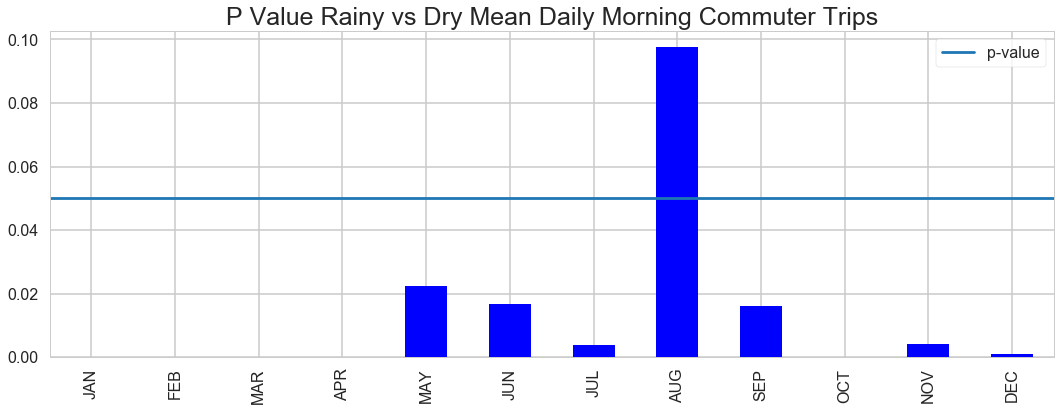

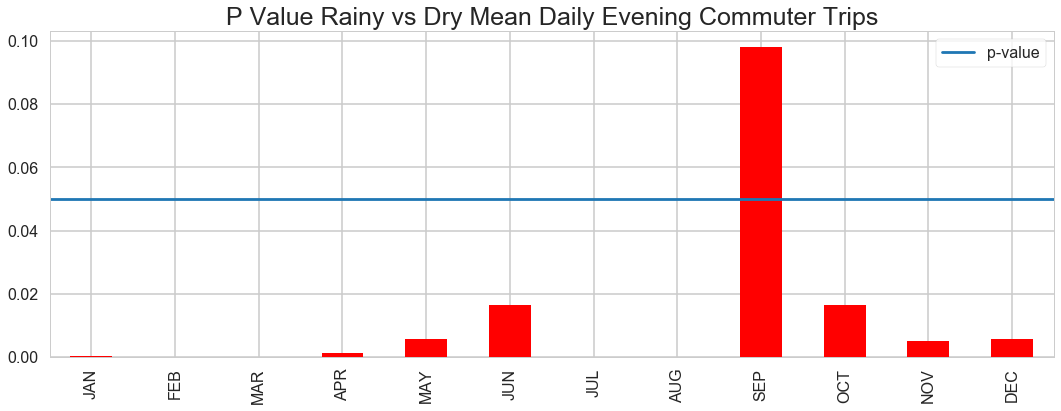

In [257]:
morning_commute_t_test[['p']].plot(kind='bar', figsize=(18,6), color='b')
plt.axhline(y=0.05, xmin=-10, xmax=12, hold=None)
plt.xticks(morning_commute_t_test.index, month_labels)
plt.legend(['p-value'], loc=1, frameon=True)
title = 'P Value Rainy vs Dry Mean Daily Morning Commuter Trips'
plt.title(title, size=TITLE_FONT_SIZE)
# plt.show()
save_path = '../charts/statistical_analysis/01_%s.png' % title.lower().replace(' ', '_')
plt.savefig(save_path)


evening_commute_t_test[['p']].plot(kind='bar', figsize=(18,6), color='r')
plt.axhline(y=0.05, xmin=-10, xmax=12, hold=None)
plt.xticks(morning_commute_t_test.index, month_labels)
plt.legend(['p-value'], loc=1, frameon=True)
title = 'P Value Rainy vs Dry Mean Daily Evening Commuter Trips'
plt.title(title, size=TITLE_FONT_SIZE)
# plt.show()
save_path = '../charts/statistical_analysis/01_%s.png' % title.lower().replace(' ', '_')
plt.savefig(save_path)

In [258]:
print('morning drop share {:3.4f}'.format(morning_commute_t_test[['drop_share']].mean()[0]))
print('evening drop share {:3.4f}'.format(evening_commute_t_test[['drop_share']].mean()[0]))

morning drop share 75.8006
evening drop share 61.8143


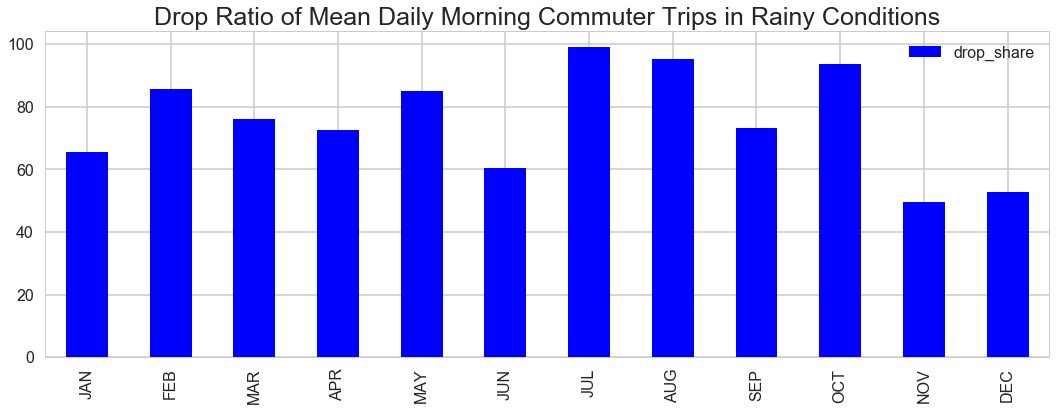

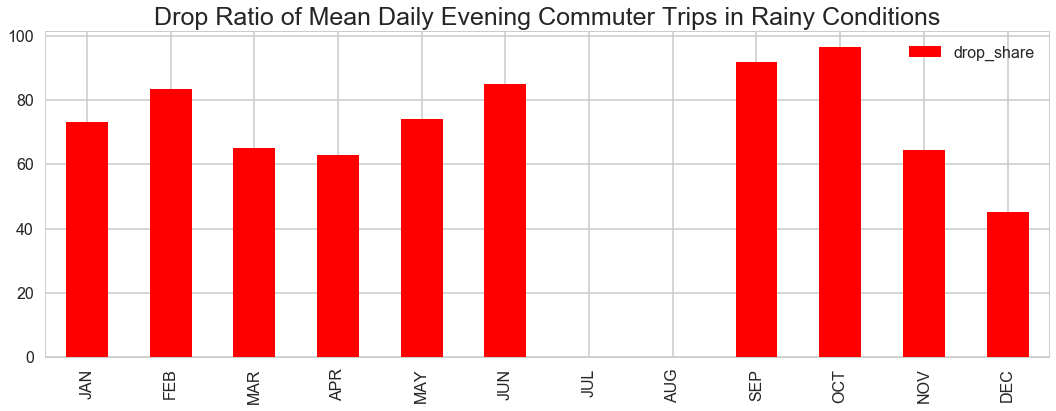

In [259]:
morning_commute_t_test[['drop_share']].plot(kind='bar', figsize=(18,6), color='b')
# plt.axhline(y=0.05, xmin=-10, xmax=12, hold=None)
plt.xticks(morning_commute_t_test.index, month_labels)
title = 'Drop Ratio of Mean Daily Morning Commuter Trips in Rainy Conditions'
plt.title(title, size=TITLE_FONT_SIZE)
# plt.legend('', loc=1, frameon=True)
# plt.show()
save_path = '../charts/statistical_analysis/01_%s.png' % title.lower().replace(' ', '_')
plt.savefig(save_path)

evening_commute_t_test[['drop_share']].plot(kind='bar', figsize=(18,6), color='r')
# plt.axhline(y=0.05, xmin=-10, xmax=12, hold=None)
plt.xticks(morning_commute_t_test.index, month_labels)
title = 'Drop Ratio of Mean Daily Evening Commuter Trips in Rainy Conditions'
plt.title(title, size=TITLE_FONT_SIZE)
# plt.legend('', loc=1, frameon=True)
# plt.show()

save_path = '../charts/statistical_analysis/01_%s.png' % title.lower().replace(' ', '_')
plt.savefig(save_path)

# Impact of Temperature on Commuter Trip Counts


<div class="alert alert-info">

<p><b>2a. Morning Commutes</b></p>

<p>A <b>Wilcoxon Rank-Sum Statistic Test</b> is appropriate for this problem as we are trying to see a difference between two sample means from data sets with very different values.</p>

<ul>
    <li>$H$o : Morning Commuter Mean Number of trips on Cold Days = Morning Commuter Mean Number of trips on Normal Days</li>
    <li>$H$a : Morning Commuter Mean Number of trips on Cold Days ≠ Morning Commuter Mean Number of trips on Normal Days</li>
</ul>

<ul>
    <li>$H$o : Morning Commuter Mean Number of trips on Hot Days = Morning Commuter Mean Number of trips on Normal Days</li>
    <li>$H$a : Morning Commuter Mean Number of trips on Hot Days ≠ Morning Commuter Mean Number of trips on Normal Days</li>
</ul>
</div>

In [260]:
# Morning Commutes
m_COLD = morning_commute_data[morning_commute_data['temp_cat'] == 'Cold']
m_COLD = m_COLD.groupby(m_COLD.start_date.dt.date)['trip_id'].count()

m_NORM = morning_commute_data[morning_commute_data['temp_cat'] == 'Normal']
m_NORM = m_NORM.groupby(m_NORM.start_date.dt.date)['trip_id'].count()

m_HOT = morning_commute_data[morning_commute_data['temp_cat'] == 'Hot']
m_HOT = m_HOT.groupby(m_HOT.start_date.dt.date)['trip_id'].count()

In [261]:
chunks = []

for month in sorted(morning_commute_data.start_date.dt.month.unique()):
    print('\nMonth of %s' % month_labels[month-1])

    month_data = morning_commute_data[morning_commute_data.start_date.dt.month == month].copy()

    # Morning Commutes
    m_HOT = month_data[month_data['temp_cat'] == 'Hot']
    m_HOT = m_HOT.groupby([m_HOT.start_date.dt.date])['trip_id'].count()

    m_NORMAL   = month_data[month_data['temp_cat'] == 'Normal']
    m_NORMAL = m_NORMAL.groupby([m_NORMAL.start_date.dt.date])['trip_id'].count()
        
    R = ranksums_test(m_NORMAL, m_HOT)
    chunks.append(R)
    print('-' * 60)


Month of JAN
A Intervals   43
B Intervals   1
A_mean        219.93023
B_mean        12.00000
Diff of Means 207.93023
Share Drop    94.54372
   z stat     1.41750
   p value    0.15634
Can not reject the null Hypothesis
------------------------------------------------------------

Month of FEB
A Intervals   51
B Intervals   3
A_mean        293.62745
B_mean        109.00000
Diff of Means 184.62745
Share Drop    62.87813
   z stat     2.13360
   p value    0.03288
Reject the null Hypothesis
------------------------------------------------------------

Month of MAR
A Intervals   66
B Intervals   2
A_mean        295.10606
B_mean        9.00000
Diff of Means 286.10606
Share Drop    96.95025
   z stat     2.26861
   p value    0.02329
Reject the null Hypothesis
------------------------------------------------------------

Month of APR
A Intervals   63
B Intervals   14
A_mean        322.61905
B_mean        99.64286
Diff of Means 222.97619
Share Drop    69.11439
   z stat     4.16686
   p valu

In [262]:
morning_hot_commute_t_test = pd.DataFrame(chunks)
morning_hot_commute_t_test['month'] = month_labels
morning_hot_commute_t_test.fillna(0, inplace=True)
morning_hot_commute_t_test

,A_intervals,A_mean,B_intervals,B_mean,can_reject,diff_of_means,drop_share,p,z,month
0,43,219.930233,1,12.000000,False,207.930233,94.543724,1.563372e-01,1.417499,JAN
1,51,293.627451,3,109.000000,True,184.627451,62.878130,3.287594e-02,2.133595,FEB
2,66,295.106061,2,9.000000,True,286.106061,96.950249,2.329228e-02,2.268606,MAR
3,63,322.619048,14,99.642857,True,222.976190,69.114391,3.088307e-05,4.166855,APR
4,64,344.515625,14,129.642857,True,214.872768,62.369528,6.051672e-06,4.524576,MAY
5,65,368.738462,44,40.750000,True,327.988462,88.948807,1.397800e-17,8.535310,JUN
6,60,290.116667,62,117.903226,True,172.213441,59.360065,1.991146e-08,5.612769,JUL
7,58,281.982759,61,163.081967,True,118.900791,42.165979,8.256722e-04,3.344042,AUG
8,55,213.490909,59,157.101695,True,56.389214,26.412935,4.263538e-02,2.027264,SEP
9,64,238.515625,34,230.411765,False,8.103860,3.397622,7.007034e-01,0.384371,OCT


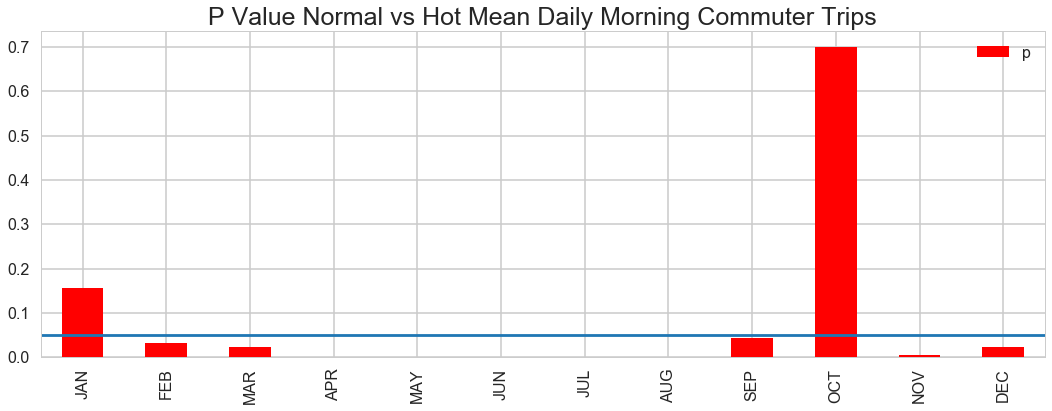

In [263]:
morning_hot_commute_t_test[['p']].plot(kind='bar', figsize=(18,6), color='r')
plt.axhline(y=0.05, xmin=-10, xmax=12, hold=None)
plt.xticks(morning_hot_commute_t_test.index, month_labels)
title = 'P Value Normal vs Hot Mean Daily Morning Commuter Trips'
plt.title(title, size=TITLE_FONT_SIZE)
# plt.show()
save_path = '../charts/statistical_analysis/02_%s.png' % title.lower().replace(' ', '_')
plt.savefig(save_path)

In [264]:
chunks = []

for month in sorted(morning_commute_data.start_date.dt.month.unique()):
    print('\nMonth of %s' % month_labels[month-1])

    month_data = morning_commute_data[morning_commute_data.start_date.dt.month == month].copy()

    # Morning Commutes
    m_COLD = month_data[month_data['temp_cat'] == 'Cold']
    m_COLD = m_COLD.groupby([m_COLD.start_date.dt.date])['trip_id'].count()

    m_NORMAL   = month_data[month_data['temp_cat'] == 'Normal']
    m_NORMAL = m_NORMAL.groupby([m_NORMAL.start_date.dt.date])['trip_id'].count()
        
    R = ranksums_test(m_NORMAL, m_COLD)
    chunks.append(R)
    print('-' * 60)


Month of JAN
A Intervals   43
B Intervals   57
A_mean        219.93023
B_mean        181.64912
Diff of Means 38.28111
Share Drop    17.40602
   z stat     1.15228
   p value    0.24921
Can not reject the null Hypothesis
------------------------------------------------------------

Month of FEB
A Intervals   51
B Intervals   43
A_mean        293.62745
B_mean        104.60465
Diff of Means 189.02280
Share Drop    64.37504
   z stat     6.36374
   p value    0.00000
Reject the null Hypothesis
------------------------------------------------------------

Month of MAR
A Intervals   66
B Intervals   37
A_mean        295.10606
B_mean        83.08108
Diff of Means 212.02498
Share Drop    71.84704
   z stat     6.30677
   p value    0.00000
Reject the null Hypothesis
------------------------------------------------------------

Month of APR
A Intervals   63
B Intervals   31
A_mean        322.61905
B_mean        68.38710
Diff of Means 254.23195
Share Drop    78.80252
   z stat     7.06110
   p 

/Users/samgutentag/anaconda/envs/spring/lib/python3.6/site-packages/scipy/stats/stats.py:4956: RuntimeWarning: invalid value encountered in double_scalars
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


A Intervals   65
B Intervals   0
A_mean        368.73846
B_mean        nan
Diff of Means nan
Share Drop    nan
   z stat     nan
   p value    nan
Can not reject the null Hypothesis
------------------------------------------------------------

Month of JUL
A Intervals   60
B Intervals   0
A_mean        290.11667
B_mean        nan
Diff of Means nan
Share Drop    nan
   z stat     nan
   p value    nan
Can not reject the null Hypothesis
------------------------------------------------------------

Month of AUG
A Intervals   58
B Intervals   0
A_mean        281.98276
B_mean        nan
Diff of Means nan
Share Drop    nan
   z stat     nan
   p value    nan
Can not reject the null Hypothesis
------------------------------------------------------------

Month of SEP
A Intervals   55
B Intervals   1
A_mean        213.49091
B_mean        5.00000
Diff of Means 208.49091
Share Drop    97.65798
   z stat     1.57765
   p value    0.11464
Can not reject the null Hypothesis
------------------------

In [265]:
morning_cold_commute_t_test = pd.DataFrame(chunks)
morning_cold_commute_t_test['month'] = month_labels
morning_cold_commute_t_test.fillna(0, inplace=True)
morning_cold_commute_t_test

,A_intervals,A_mean,B_intervals,B_mean,can_reject,diff_of_means,drop_share,p,z,month
0,43,219.930233,57,181.649123,False,38.281110,17.406024,2.492079e-01,1.152275,JAN
1,51,293.627451,43,104.604651,True,189.022800,64.375044,1.968966e-10,6.363742,FEB
2,66,295.106061,37,83.081081,True,212.024980,71.847043,2.849133e-10,6.306773,MAR
3,63,322.619048,31,68.387097,True,254.231951,78.802524,1.651925e-12,7.061098,APR
4,64,344.515625,6,10.833333,True,333.682292,96.855489,1.234084e-04,3.839255,MAY
5,65,368.738462,0,0.000000,False,0.000000,0.000000,0.000000e+00,0.000000,JUN
6,60,290.116667,0,0.000000,False,0.000000,0.000000,0.000000e+00,0.000000,JUL
7,58,281.982759,0,0.000000,False,0.000000,0.000000,0.000000e+00,0.000000,AUG
8,55,213.490909,1,5.000000,False,208.490909,97.657980,1.146449e-01,1.577655,SEP
9,64,238.515625,17,71.294118,True,167.221507,70.109246,1.105172e-05,4.395502,OCT


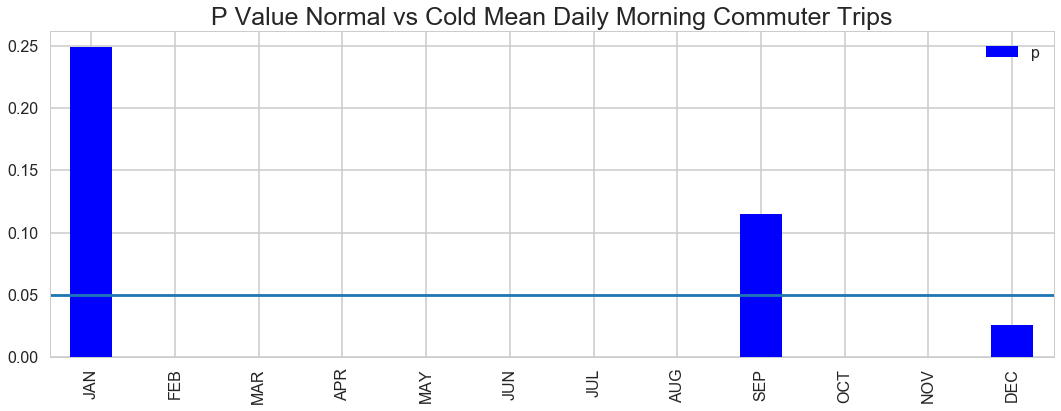

In [266]:
morning_cold_commute_t_test[['p']].plot(kind='bar', figsize=(18,6), color='b')
plt.axhline(y=0.05, xmin=-10, xmax=12, hold=None)
plt.xticks(morning_cold_commute_t_test.index, month_labels)
title = 'P Value Normal vs Cold Mean Daily Morning Commuter Trips'
plt.title(title, size=TITLE_FONT_SIZE)
# plt.show()
save_path = '../charts/statistical_analysis/02_%s.png' % title.lower().replace(' ', '_')
plt.savefig(save_path)

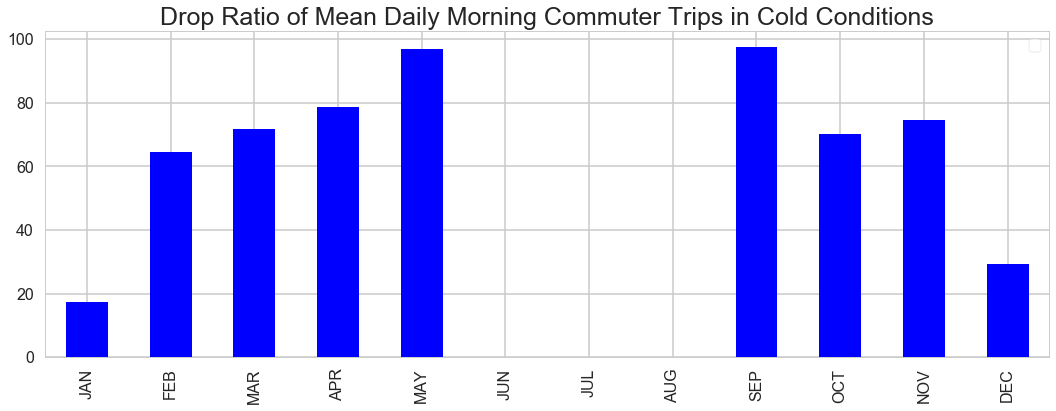

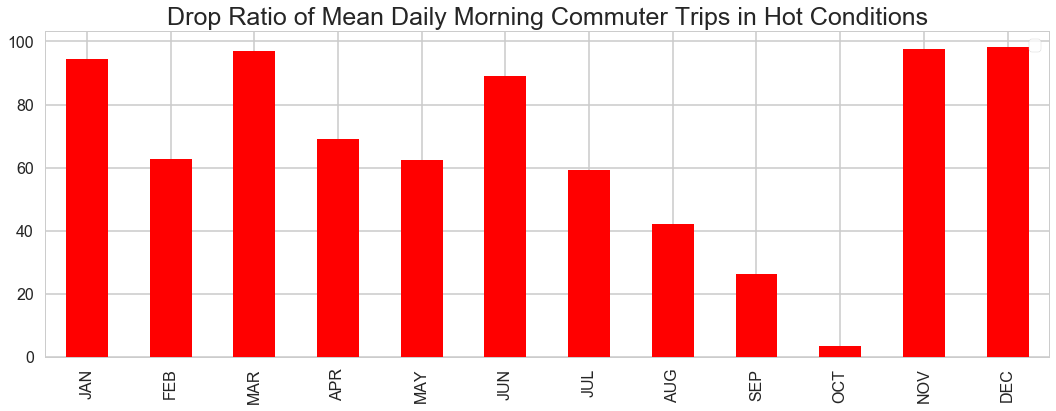

In [267]:
morning_cold_commute_t_test[['drop_share']].plot(kind='bar', figsize=(18,6), color='b')
# plt.axhline(y=0.05, xmin=-10, xmax=12, hold=None)
plt.xticks(morning_cold_commute_t_test.index, month_labels)
title = 'Drop Ratio of Mean Daily Morning Commuter Trips in Cold Conditions'
plt.title(title, size=TITLE_FONT_SIZE)
plt.legend('', loc=1, frameon=True)
# plt.show()
save_path = '../charts/statistical_analysis/02_%s.png' % title.lower().replace(' ', '_')
plt.savefig(save_path)

morning_hot_commute_t_test[['drop_share']].plot(kind='bar', figsize=(18,6), color='r')
# plt.axhline(y=0.05, xmin=-10, xmax=12, hold=None)
plt.xticks(morning_hot_commute_t_test.index, month_labels)
title = 'Drop Ratio of Mean Daily Morning Commuter Trips in Hot Conditions'
plt.title(title, size=TITLE_FONT_SIZE)
plt.legend('', loc=1, frameon=True)
# plt.show()
save_path = '../charts/statistical_analysis/02_%s.png' % title.lower().replace(' ', '_')
plt.savefig(save_path)


<div class="alert alert-info">

<p><b>2b. Evening Commutes</b></p>


<p>A <b>Wilcoxon Rank-Sum Statistic Test</b> is appropriate for this problem as we are trying to see a difference between two sample means from data sets with very different values.</p>


<ul>
    <li>$H$o : Evening Commuter Mean Number of trips on Cold Days = Evening Commuter Mean Number of trips on Normal Days</li>
    <li>$H$a : Evening Commuter Mean Number of trips on Cold Days ≠ Evening Commuter Mean Number of trips on Normal Days</li>
</ul>

<ul>
    <li>$H$o : Evening Commuter Mean Number of trips on Hot Days = Evening Commuter Mean Number of trips on Normal Days</li>
    <li>$H$a : Evening Commuter Mean Number of trips on Hot Days ≠ Evening Commuter Mean Number of trips on Normal Days</li>
</ul>
</div>

In [268]:
# Evening Commutes
e_COLD = evening_commute_data[evening_commute_data['temp_cat'] == 'Cold']
e_COLD = e_COLD.groupby(e_COLD.start_date.dt.date)['trip_id'].count()

e_NORM = evening_commute_data[evening_commute_data['temp_cat'] == 'Normal']
e_NORM = e_NORM.groupby(e_NORM.start_date.dt.date)['trip_id'].count()

e_HOT = evening_commute_data[evening_commute_data['temp_cat'] == 'Hot']
e_HOT = e_HOT.groupby(e_HOT.start_date.dt.date)['trip_id'].count()

In [269]:
chunks = []

for month in sorted(evening_commute_data.start_date.dt.month.unique()):
    print('\nMonth of %s' % month_labels[month-1])

    month_data = evening_commute_data[evening_commute_data.start_date.dt.month == month].copy()

    # Morning Commutes
    e_HOT = month_data[month_data['temp_cat'] == 'Hot']
    e_HOT = e_HOT.groupby([e_HOT.start_date.dt.date])['trip_id'].count()

    e_NORMAL   = month_data[month_data['temp_cat'] == 'Normal']
    e_NORMAL = e_NORMAL.groupby([e_NORMAL.start_date.dt.date])['trip_id'].count()
        
    R = ranksums_test(e_NORMAL, e_HOT)
    chunks.append(R)
    print('-' * 60)


Month of JAN
A Intervals   57
B Intervals   3
A_mean        164.77193
B_mean        11.33333
Diff of Means 153.43860
Share Drop    93.12181
   z stat     2.01811
   p value    0.04358
Reject the null Hypothesis
------------------------------------------------------------

Month of FEB
A Intervals   52
B Intervals   10
A_mean        244.26923
B_mean        51.70000
Diff of Means 192.56923
Share Drop    78.83483
   z stat     4.06703
   p value    0.00005
Reject the null Hypothesis
------------------------------------------------------------

Month of MAR
A Intervals   63
B Intervals   17
A_mean        276.69841
B_mean        68.52941
Diff of Means 208.16900
Share Drop    75.23317
   z stat     4.75154
   p value    0.00000
Reject the null Hypothesis
------------------------------------------------------------

Month of APR
A Intervals   57
B Intervals   23
A_mean        283.66667
B_mean        123.91304
Diff of Means 159.75362
Share Drop    56.31738
   z stat     4.14583
   p value    

/Users/samgutentag/anaconda/envs/spring/lib/python3.6/site-packages/scipy/stats/stats.py:4956: RuntimeWarning: invalid value encountered in double_scalars
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


In [270]:
evening_hot_commute_t_test = pd.DataFrame(chunks)
evening_hot_commute_t_test['month'] = month_labels
evening_hot_commute_t_test.fillna(0, inplace=True)
evening_hot_commute_t_test

,A_intervals,A_mean,B_intervals,B_mean,can_reject,diff_of_means,drop_share,p,z,month
0,57,164.771930,3,11.333333,True,153.438596,93.121806,4.357991e-02,2.018109,JAN
1,52,244.269231,10,51.700000,True,192.569231,78.834829,4.761567e-05,4.067032,FEB
2,63,276.698413,17,68.529412,True,208.169001,75.233175,2.018693e-06,4.751544,MAR
3,57,283.666667,23,123.913043,True,159.753623,56.317376,3.385866e-05,4.145829,APR
4,60,295.133333,25,104.880000,True,190.253333,64.463519,7.142213e-07,4.957456,MAY
5,63,318.571429,58,67.068966,True,251.502463,78.946961,6.672799e-18,8.620387,JUN
6,63,293.190476,65,69.415385,True,223.775092,76.324134,3.138004e-14,7.592496,JUL
7,62,317.387097,67,62.552239,True,254.834858,80.291499,3.100939e-17,8.442699,AUG
8,56,249.767857,63,95.761905,True,154.005952,61.659636,1.106167e-09,6.093285,SEP
9,59,257.711864,53,122.528302,True,135.183563,52.455312,8.849821e-06,4.443522,OCT


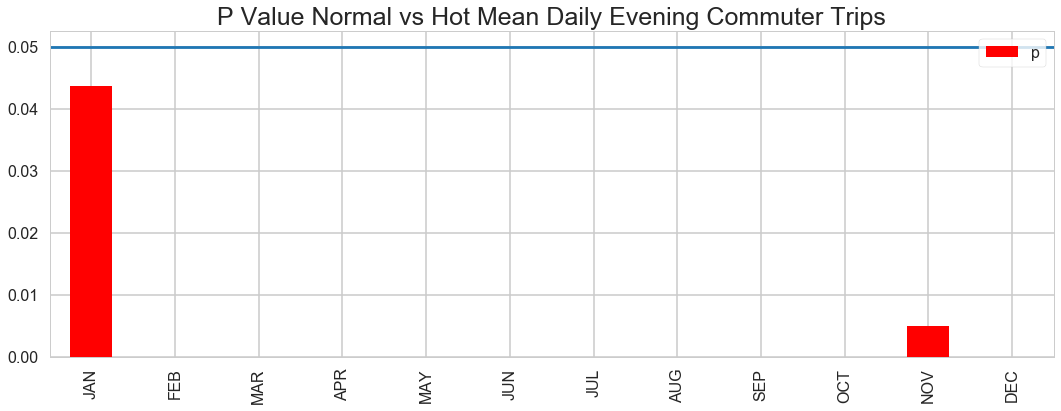

In [271]:
evening_hot_commute_t_test[['p']].plot(kind='bar', figsize=(18,6), color='r')
plt.axhline(y=0.05, xmin=-10, xmax=12, hold=None)
plt.xticks(evening_hot_commute_t_test.index, month_labels)
title = 'P Value Normal vs Hot Mean Daily Evening Commuter Trips'
plt.legend(loc=1, frameon=True)
plt.title(title, size=TITLE_FONT_SIZE)
# plt.show()
save_path = '../charts/statistical_analysis/02_%s.png' % title.lower().replace(' ', '_')
plt.savefig(save_path)

In [272]:
chunks = []

for month in sorted(evening_commute_data.start_date.dt.month.unique()):
    print('\nMonth of %s' % month_labels[month-1])

    month_data = evening_commute_data[evening_commute_data.start_date.dt.month == month].copy()

    # Morning Commutes
    e_COLD = month_data[month_data['temp_cat'] == 'Cold']
    e_COLD = e_COLD.groupby([e_COLD.start_date.dt.date])['trip_id'].count()

    e_NORMAL   = month_data[month_data['temp_cat'] == 'Normal']
    e_NORMAL = e_NORMAL.groupby([e_NORMAL.start_date.dt.date])['trip_id'].count()
        
    R = ranksums_test(e_NORMAL, e_COLD)
    chunks.append(R)
    print('-' * 60)


Month of JAN
A Intervals   57
B Intervals   52
A_mean        164.77193
B_mean        178.86538
Diff of Means -14.09345
Share Drop    -8.55331
   z stat     -0.50051
   p value    0.61672
Can not reject the null Hypothesis
------------------------------------------------------------

Month of FEB
A Intervals   52
B Intervals   27
A_mean        244.26923
B_mean        176.18519
Diff of Means 68.08405
Share Drop    27.87254
   z stat     2.44452
   p value    0.01450
Reject the null Hypothesis
------------------------------------------------------------

Month of MAR
A Intervals   63
B Intervals   15
A_mean        276.69841
B_mean        155.80000
Diff of Means 120.89841
Share Drop    43.69321
   z stat     3.40412
   p value    0.00066
Reject the null Hypothesis
------------------------------------------------------------

Month of APR
A Intervals   57
B Intervals   14
A_mean        283.66667
B_mean        221.07143
Diff of Means 62.59524
Share Drop    22.06648
   z stat     2.47849
   

/Users/samgutentag/anaconda/envs/spring/lib/python3.6/site-packages/scipy/stats/stats.py:4956: RuntimeWarning: invalid value encountered in double_scalars
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


A Intervals   63
B Intervals   0
A_mean        293.19048
B_mean        nan
Diff of Means nan
Share Drop    nan
   z stat     nan
   p value    nan
Can not reject the null Hypothesis
------------------------------------------------------------

Month of AUG
A Intervals   62
B Intervals   0
A_mean        317.38710
B_mean        nan
Diff of Means nan
Share Drop    nan
   z stat     nan
   p value    nan
Can not reject the null Hypothesis
------------------------------------------------------------

Month of SEP
A Intervals   56
B Intervals   0
A_mean        249.76786
B_mean        nan
Diff of Means nan
Share Drop    nan
   z stat     nan
   p value    nan
Can not reject the null Hypothesis
------------------------------------------------------------

Month of OCT
A Intervals   59
B Intervals   8
A_mean        257.71186
B_mean        178.87500
Diff of Means 78.83686
Share Drop    30.59109
   z stat     2.15596
   p value    0.03109
Reject the null Hypothesis
-------------------------------

In [273]:
evening_cold_commute_t_test = pd.DataFrame(chunks)
evening_cold_commute_t_test['month'] = month_labels
evening_cold_commute_t_test.fillna(0, inplace=True)
evening_cold_commute_t_test

,A_intervals,A_mean,B_intervals,B_mean,can_reject,diff_of_means,drop_share,p,z,month
0,57,164.771930,52,178.865385,False,-14.093455,-8.553311,0.616719,-0.500506,JAN
1,52,244.269231,27,176.185185,True,68.084046,27.872543,0.014505,2.444518,FEB
2,63,276.698413,15,155.800000,True,120.898413,43.693208,0.000664,3.404125,MAR
3,57,283.666667,14,221.071429,True,62.595238,22.066476,0.013194,2.478489,APR
4,60,295.133333,12,118.500000,True,176.633333,59.848656,0.000136,3.815262,MAY
5,63,318.571429,3,63.000000,True,255.571429,80.224215,0.005337,2.785934,JUN
6,63,293.190476,0,0.000000,False,0.000000,0.000000,0.000000,0.000000,JUL
7,62,317.387097,0,0.000000,False,0.000000,0.000000,0.000000,0.000000,AUG
8,56,249.767857,0,0.000000,False,0.000000,0.000000,0.000000,0.000000,SEP
9,59,257.711864,8,178.875000,True,78.836864,30.591088,0.031087,2.155957,OCT


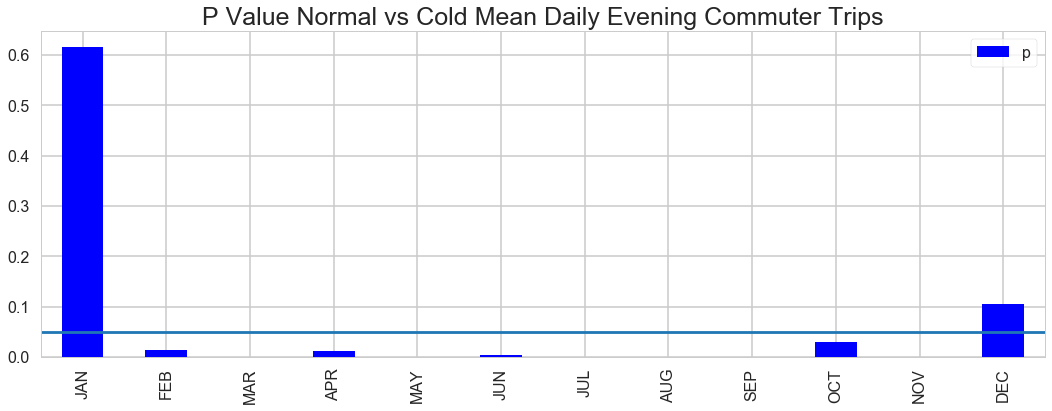

In [274]:
evening_cold_commute_t_test[['p']].plot(kind='bar', figsize=(18,6), color='b')
plt.axhline(y=0.05, xmin=-10, xmax=12, hold=None)
plt.xticks(evening_cold_commute_t_test.index, month_labels)
title = 'P Value Normal vs Cold Mean Daily Evening Commuter Trips'
plt.legend(loc=1, frameon=True)
plt.title(title, size=TITLE_FONT_SIZE)
# plt.show()
save_path = '../charts/statistical_analysis/02_%s.png' % title.lower().replace(' ', '_')
plt.savefig(save_path)

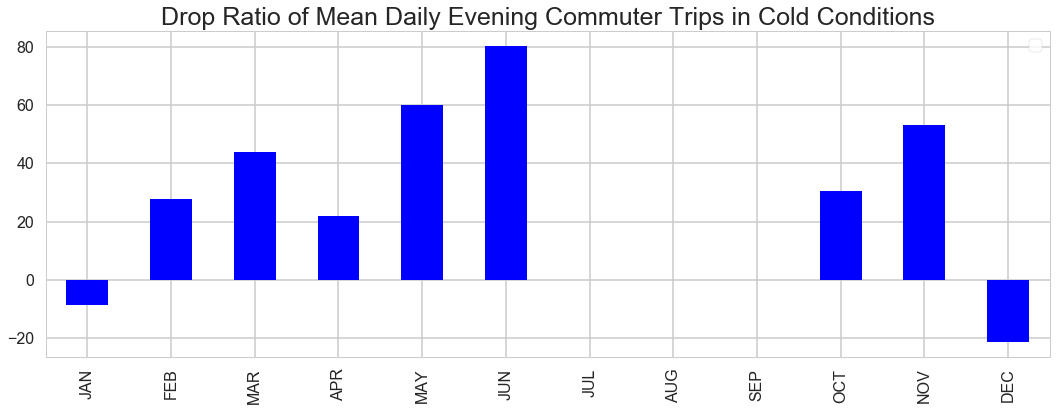

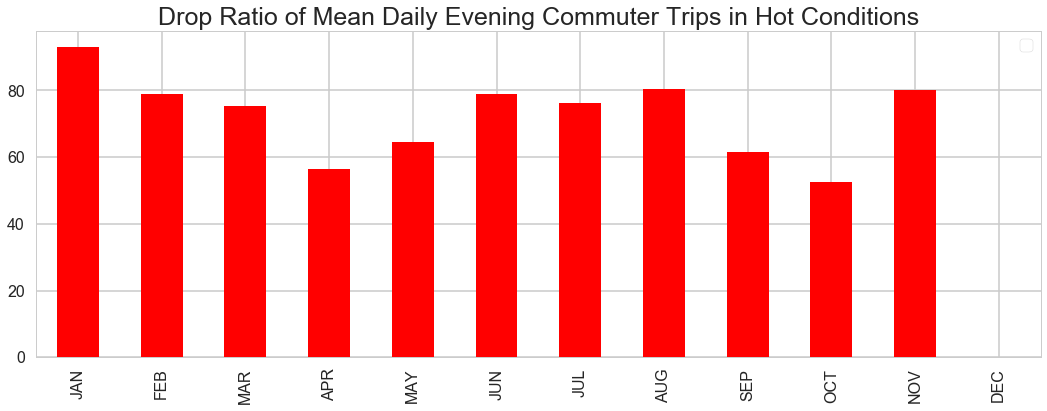

In [275]:
evening_cold_commute_t_test[['drop_share']].plot(kind='bar', figsize=(18,6), color='b')
# plt.axhline(y=0.05, xmin=-10, xmax=12, hold=None)
plt.xticks(evening_cold_commute_t_test.index, month_labels)
title = 'Drop Ratio of Mean Daily Evening Commuter Trips in Cold Conditions'
plt.title(title, size=TITLE_FONT_SIZE)
plt.legend('', loc=1, frameon=True)
# plt.show()
save_path = '../charts/statistical_analysis/02_%s.png' % title.lower().replace(' ', '_')
plt.savefig(save_path)

evening_hot_commute_t_test[['drop_share']].plot(kind='bar', figsize=(18,6), color='r')
# plt.axhline(y=0.05, xmin=-10, xmax=12, hold=None)
plt.xticks(evening_hot_commute_t_test.index, month_labels)
title = 'Drop Ratio of Mean Daily Evening Commuter Trips in Hot Conditions'
plt.title(title, size=TITLE_FONT_SIZE)
plt.legend('', loc=1, frameon=True)
# plt.show()
save_path = '../charts/statistical_analysis/02_%s.png' % title.lower().replace(' ', '_')
plt.savefig(save_path)

In [278]:
evening_cold_commute_t_test[['drop_share']].sum()/9

drop_share    31.952186
dtype: float64